In [1]:
import numpy as np
import numpy.linalg as LA
from load_mnist import loadImageSet, loadLabelSet

%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from sklearn import neighbors
import pdb


# 数据加载

In [2]:
train_images = loadImageSet('MNIST_data/train-images-idx3-ubyte') 
train_labels = loadLabelSet('MNIST_data/train-labels-idx1-ubyte')

test_images = loadImageSet('MNIST_data/t10k-images-idx3-ubyte') 
test_labels = loadLabelSet('MNIST_data/t10k-labels-idx1-ubyte')

train_x = train_images[0:2000,:] /255.0
train_x = train_x.T
train_y = train_labels[0:2000]

test_x = test_images[0:2000,:] /255.0 
test_x = test_x.T
test_y = test_labels[0:2000]

# 可视化函数

In [3]:
#%%
# 将降维后的数据可视化,2维
def plot_embedding_2d(X, y, title=None):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)

    #降维后的坐标为（X[i, 0], X[i, 1]），在该位置画出对应的digits
    fig = plt.figure()
#     plt.axis([-2000, 2000,-2000,2000])
    ax = fig.add_subplot(1, 1, 1)
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if title is not None:
        plt.title(title)
#         plt.savefig(title.replace(' ','_')+".png") 

# 进行LLE降维需要的函数

In [4]:
def EuclideanDistances(A, B):
    BT = B.transpose()
    # vecProd = A * BT
    vecProd = np.dot(A,BT)
    # print(vecProd)
    SqA =  A**2
    # print(SqA)
    sumSqA = np.matrix(np.sum(SqA, axis=1))
    sumSqAEx = np.tile(sumSqA.transpose(), (1, vecProd.shape[1]))
    # print(sumSqAEx)

    SqB = B**2
    sumSqB = np.sum(SqB, axis=1)
    sumSqBEx = np.tile(sumSqB, (vecProd.shape[0], 1))    
    SqED = sumSqBEx + sumSqAEx - 2*vecProd
    SqED[SqED<0]=0.0   
    ED = np.array(np.sqrt(SqED))
    return ED

In [5]:
def get_neighbors_ind(X, K=10):
    """
    Param:
        X: M * N matrix
        Y: matrix
        K: The number of neighbors of each point
    """    
#     M, N = X.shape
#     X2 = np.sum(X**2, axis=0, keepdims=True)
#     distance = np.tile(X2,(N,1))+np.tile(X2.T,(1,N))-2 * np.matmul(X.T, X)
    distance = EuclideanDistances(X.T, X.T)
    index = np.argsort(distance, axis=0)
    neighborhood = index[1:(1+K),:]                                    
    return neighborhood

In [6]:
def get_neighbors_ind2(X, K=10):
    """
    Param:
        X: M * N matrix
        Y: matrix
        K: The number of neighbors of each point
    """    
    M, N = X.shape
    X2 = np.sum(X**2, axis=0, keepdims=True)
    distance = np.tile(X2,(N,1))+np.tile(X2.T,(1,N))-2 * np.matmul(X.T, X)
#     distance = EuclideanDistances(X.T, X.T)
    index = np.argsort(distance, axis=0)
    neighborhood = index[1:(1+K),:]                                    
    return neighborhood

In [7]:
def get_weight(X, neighborhood):
    M, N = X.shape
    K = neighborhood.shape[0]
    if K > M:
        tol=1e-3
    else:
        tol=0
    W = np.zeros((N, N))
    for i in xrange(N):
        z = X[:,neighborhood[:,i]] - np.expand_dims(X[:,i], 1)
        G = np.matmul(z.T, z)
        G = G + np.identity(K) * tol * np.trace(G)
        
        G_I = LA.inv(G)
        W[i,neighborhood[:,i]] = np.matmul(G_I, np.ones(K))  # np.matmul(G_I, np.ones(K)) 的结果是一个列向量，我们将其放在W的行中
        W[i,neighborhood[:,i]] = W[i, neighborhood[:,i]] / np.sum(W[i,:])  
#         W[:,i]=np.sum(G_I, axis=1) / np.sum(G_I)
    return W   

In [8]:
def get_LLE_matrix(W):
    N = W.shape[1]
    I = np.identity(N)
    M = np.matmul((I-W.T),(I-W))
    return M

In [9]:
def get_embedding(M, d):
    N = M.shape[0]
    eigenValues, eigenVectors = LA.eig(M)
    eigValInd=np.argsort(eigenValues)
    eigValInd=eigValInd[1:(d+1)]
    Y_T = eigenVectors[:, eigValInd]
    Y = Y_T.T
    return Y

In [10]:
train_x_neighbor = get_neighbors_ind(train_x, K=9)
W = get_weight(train_x, train_x_neighbor)

# 对训练数据进行LLE降维

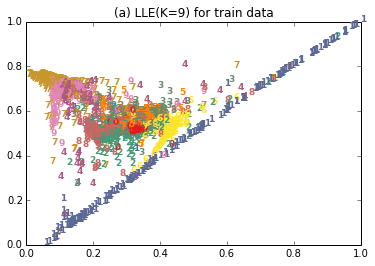

In [10]:
train_x_neighbor = get_neighbors_ind(train_x, K=9)
W = get_weight(train_x, train_x_neighbor)
M = get_LLE_matrix(W)
embedding_train = get_embedding(M, d=2)
plot_embedding_2d(embedding_train.T, train_y, title='(a) LLE(K=9) for train data')

# 对测试数据进行LLE降维

In [11]:
test_x_neighbor = get_neighbors_ind(test_x, K=9)
W = get_weight(test_x, test_x_neighbor)
M = get_LLE_matrix(W)
embedding_test = get_embedding(M, d=2)
# plot_embedding_2d(embedding_test.T, test_y, title='(b) LLE(K=9) for test data')

# 对test数据使用train数据进行最近邻插值

In [12]:
def get_weight_interpolation(test_X, train_X, neighborhood):
    X = test_X
    M, N = X.shape
    K = neighborhood.shape[1]
    if K > M:
        tol=1e-3
    else:
        tol=0
    W = np.zeros((N, N))
    for i in xrange(N):
        z = np.expand_dims(X[:,i], 1) - train_X[:,neighborhood[i,:]]
        G = np.matmul(z.T, z)
        G = G + np.identity(K) * tol * np.trace(G)
        
        G_I = LA.inv(G)
        W[i,neighborhood[i,:]] = np.matmul(G_I, np.ones(K))  # np.matmul(G_I, np.ones(K)) 的结果是一个列向量，我们将其放在W的行中
        W[i,neighborhood[i,:]] = W[i, neighborhood[i,:]] / np.sum(W[i,:])  
#         W[:,i]=np.sum(G_I, axis=1) / np.sum(G_I)
    return W   

In [ ]:
### 对test数据使用train数据进行最近邻插值
distance = EuclideanDistances(test_x.T, train_x.T)
index = np.argsort(distance, axis=1)
neighborhood = index[:,0:K] 
W = get_weight_interpolation(test_x, train_x, neighborhood)
embedding_interpolation_test = np.matmul(W,embedding_train.T)
embedding_interpolation_test = embedding_interpolation_test.T


# 调库实现KNN

In [19]:
''''' 训练KNN分类器 '''  
clf = neighbors.KNeighborsClassifier(algorithm='auto',n_neighbors=1, weights= 'distance')  
clf.fit(embedding_train.T, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance')

In [27]:
"""测试准确率"""
acc = np.float(sum(test_y==clf.predict(embedding_interpolation_test.T))) / len(test_y)
print acc

0.8675
